In [1]:
import os
import joblib
from tqdm import tqdm
from IPython.display import Image, display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchinfo import summary
from torchviz import make_dot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## LSTM

### Data Importing

In [3]:
df = pd.read_csv("./.data/train_aug.csv")

In [4]:
print(df)

               id   bg-1:55   bg-1:50   bg-1:45   bg-1:40   bg-1:35   bg-1:30  \
0           p01_0  3.103256  3.207739  3.306019  3.338826  3.354246  3.385527   
1           p01_1  3.334344  3.368640  3.382463  3.342868  3.303760  3.241867   
2           p01_2  3.351738  3.290329  3.235490  3.198546  3.087441  2.998913   
3           p01_3  3.164014  3.096026  3.013504  3.049034  3.062024  3.092045   
4           p01_4  3.036686  3.041001  3.069754  3.055564  3.022660  2.999762   
...           ...       ...       ...       ...       ...       ...       ...   
354043  p12_25294 -0.143842 -0.166453 -0.178820 -0.190547 -0.300671 -0.393663   
354044  p12_25295 -0.173634 -0.161785 -0.186081 -0.298534 -0.412794 -0.461140   
354045  p12_25296 -0.205563 -0.200199 -0.298250 -0.389232 -0.461662 -0.512562   
354046  p12_25297 -0.188150 -0.278181 -0.400960 -0.453957 -0.532632 -0.628098   
354047  p12_25298 -0.291531 -0.394955 -0.461099 -0.537074 -0.637675 -0.692059   

         bg-1:25   bg-1:20 

In [5]:
for col in df.columns:
    print(col)

id
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-1:55
insulin-1:50
insulin-1:45
insulin-1:40
insulin-1:35
insulin-1:30
insulin-1:25
insulin-1:20
insulin-1:15
insulin-1:10
insulin-1:05
insulin-1:00
insulin-0:55
insulin-0:50
insulin-0:45
insulin-0:40
insulin-0:35
insulin-0:30
insulin-0:25
insulin-0:20
insulin-0:15
insulin-0:10
insulin-0:05
insulin-0:00
carbs-1:55
carbs-1:50
carbs-1:45
carbs-1:40
carbs-1:35
carbs-1:30
carbs-1:25
carbs-1:20
carbs-1:15
carbs-1:10
carbs-1:05
carbs-1:00
carbs-0:55
carbs-0:50
carbs-0:45
carbs-0:40
carbs-0:35
carbs-0:30
carbs-0:25
carbs-0:20
carbs-0:15
carbs-0:10
carbs-0:05
carbs-0:00
hr-1:55
hr-1:50
hr-1:45
hr-1:40
hr-1:35
hr-1:30
hr-1:25
hr-1:20
hr-1:15
hr-1:10
hr-1:05
hr-1:00
hr-0:55
hr-0:50
hr-0:45
hr-0:40
hr-0:35
hr-0:30
hr-0:25
hr-0:20
hr-0:15
hr-0:10
hr-0:05
hr-0:00
steps-1:55
steps-1:50
steps-1:45
step

### Data Splitting

In [6]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [7]:
print(f"Train Shape: {train_df.shape}")
print(f"Validation Shape: {val_df.shape}")
print(f"Test Shape: {test_df.shape}")

Train Shape: (283238, 146)
Validation Shape: (35405, 146)
Test Shape: (35405, 146)


### Dataset and DataLoader

In [8]:
class BrisT1DDataset(Dataset):
    def __init__(self, df, is_train=True):
        
        self.df = df
        self.is_train = is_train
        
        if 'id' in self.df.columns:
            self.ids = self.df['id'].values
            self.df = self.df.drop(columns=['id'])
        else:
            self.ids = None
        
        
        if self.is_train and 'bg+1:00' in self.df.columns:
            self.targets = self.df['bg+1:00'].values
            self.df = self.df.drop(columns=['bg+1:00'])
        else:
            self.targets = None
        
        
        data = self.df.values.astype(np.float32)
        if data.shape[1] != 144:
            raise ValueError(f"Expected 144, Real  {data.shape[1]}")

        self.X = data.reshape(-1, 6, 24).transpose(0, 2, 1)
        
        if self.is_train:
            self.y = self.targets.astype(np.float32).reshape(-1, 1)
        else:
            self.y = None

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        sample = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.is_train:
            target = torch.tensor(self.y[idx], dtype=torch.float32)
            return sample, target
        else:
            return sample

In [9]:
train_dataset = BrisT1DDataset(train_df, is_train=True)
val_dataset = BrisT1DDataset(val_df, is_train=True)
test_dataset = BrisT1DDataset(test_df, is_train=True)

In [10]:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model

In [11]:
class BrisT1DLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=64, num_layers=2, dropout=0.25):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc1(out)
        out = torch.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [12]:
model = BrisT1DLSTM(input_size=6, hidden_size=64, num_layers=2, dropout=0.25).to(device)
print(model)

BrisT1DLSTM(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True, dropout=0.25)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


#### Model Summary

In [13]:
dummy_seq = torch.randn(1, 24, 6).to(device)

In [14]:
print("Model Summary:")
print(summary(model, input_data=[dummy_seq]))

Model Summary:
Layer (type:depth-idx)                   Output Shape              Param #
BrisT1DLSTM                              [1, 1]                    --
├─LSTM: 1-1                              [1, 24, 64]               51,712
├─Dropout: 1-2                           [1, 64]                   --
├─Linear: 1-3                            [1, 32]                   2,080
├─Dropout: 1-4                           [1, 32]                   --
├─Linear: 1-5                            [1, 1]                    33
Total params: 53,825
Trainable params: 53,825
Non-trainable params: 0
Total mult-adds (M): 1.24
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.22
Estimated Total Size (MB): 0.23


#### Model Computational Graph

In [15]:
dummy_output = model(dummy_seq)
dot = make_dot(dummy_output, params=dict(model.named_parameters()))

Model Computational Graph:


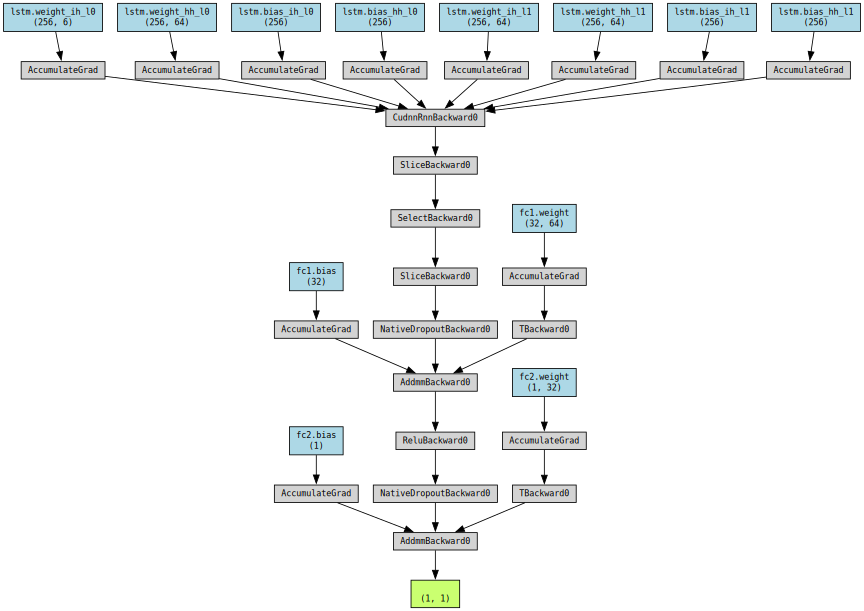

In [16]:
print("Model Computational Graph:")
display(dot)

### Training

In [50]:
epochs = 100
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
patience = 10

In [51]:
train_losses = []
val_losses = []
best_val_loss = float("inf")
epochs_no_improve = 0

In [ ]:
train_losses = []
val_losses = []
best_val_loss = float("inf")
epochs_no_improve = 0

for epoch in range(epochs):
    # Training
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * X_batch.size(0)
        
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False):
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            running_val_loss += loss.item() * X_val.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), './.export/checkpoint-aug-lstm.pt')
    else:
        epochs_no_improve += 1
        print(f"Early Stopping: {epochs_no_improve}/{patience}")
        
    if epochs_no_improve >= patience:
        print("Early Stopping!")
        break

Epoch: 1/100 | Train Loss: 0.5089 | Val Loss: 0.4478


Epoch: 2/100 | Train Loss: 0.4661 | Val Loss: 0.4370


Epoch: 3/100 | Train Loss: 0.4524 | Val Loss: 0.4271


Epoch: 4/100 | Train Loss: 0.4425 | Val Loss: 0.4167


Epoch: 5/100 | Train Loss: 0.4337 | Val Loss: 0.4122


Epoch: 6/100 | Train Loss: 0.4270 | Val Loss: 0.4052


Epoch: 7/100 | Train Loss: 0.4192 | Val Loss: 0.3972


Epoch: 8/100 | Train Loss: 0.4112 | Val Loss: 0.3889


Epoch: 9/100 | Train Loss: 0.4034 | Val Loss: 0.3836


Epoch: 10/100 | Train Loss: 0.3947 | Val Loss: 0.3754


Epoch: 11/100 | Train Loss: 0.3847 | Val Loss: 0.3580


Epoch: 12/100 | Train Loss: 0.3753 | Val Loss: 0.3507


Epoch: 13/100 | Train Loss: 0.3656 | Val Loss: 0.3443


Epoch: 14/100 | Train Loss: 0.3570 | Val Loss: 0.3306


Epoch: 15/100 | Train Loss: 0.3469 | Val Loss: 0.3231


Epoch: 16/100 | Train Loss: 0.3386 | Val Loss: 0.3120


Epoch: 17/100 | Train Loss: 0.3294 | Val Loss: 0.3058


Epoch: 18/100 | Train Loss: 0.3220 | Val Loss: 0.2978


Epoch: 19/100 | Train Loss: 0.3128 | Val Loss: 0.2869


Epoch: 20/100 | Train Loss: 0.3052 | Val Loss: 0.2812


Epoch: 21/100 | Train Loss: 0.2973 | Val Loss: 0.2713


Epoch: 22/100 | Train Loss: 0.2910 | Val Loss: 0.2668


Epoch: 23/100 | Train Loss: 0.2843 | Val Loss: 0.2626


Epoch: 24/100 | Train Loss: 0.2782 | Val Loss: 0.2523


Epoch: 25/100 | Train Loss: 0.2722 | Val Loss: 0.2492


Epoch: 26/100 | Train Loss: 0.2665 | Val Loss: 0.2413


Epoch: 27/100 | Train Loss: 0.2616 | Val Loss: 0.2396


Epoch: 28/100 | Train Loss: 0.2572 | Val Loss: 0.2340


Epoch: 29/100 | Train Loss: 0.2528 | Val Loss: 0.2281


Epoch: 30/100 | Train Loss: 0.2490 | Val Loss: 0.2248


Epoch: 31/100 | Train Loss: 0.2446 | Val Loss: 0.2224


Epoch: 32/100 | Train Loss: 0.2405 | Val Loss: 0.2160


Epoch: 33/100 | Train Loss: 0.2369 | Val Loss: 0.2100


Epoch: 34/100 | Train Loss: 0.2337 | Val Loss: 0.2070


Epoch: 35/100 | Train Loss: 0.2309 | Val Loss: 0.2085
Early Stopping: 1/10


Epoch: 36/100 | Train Loss: 0.2284 | Val Loss: 0.1995


Epoch: 37/100 | Train Loss: 0.2252 | Val Loss: 0.1974


Epoch: 38/100 | Train Loss: 0.2222 | Val Loss: 0.1981
Early Stopping: 1/10


Epoch: 39/100 | Train Loss: 0.2200 | Val Loss: 0.1932


Epoch: 40/100 | Train Loss: 0.2170 | Val Loss: 0.1923


Epoch: 41/100 | Train Loss: 0.2152 | Val Loss: 0.1886


Epoch: 42/100 | Train Loss: 0.2133 | Val Loss: 0.1888
Early Stopping: 1/10


Epoch: 43/100 | Train Loss: 0.2100 | Val Loss: 0.1853


Epoch: 44/100 | Train Loss: 0.2088 | Val Loss: 0.1825


Epoch: 45/100 | Train Loss: 0.2073 | Val Loss: 0.1827
Early Stopping: 1/10


Epoch: 46/100 | Train Loss: 0.2047 | Val Loss: 0.1768


Epoch: 47/100 | Train Loss: 0.2028 | Val Loss: 0.1762


Epoch: 48/100 | Train Loss: 0.2012 | Val Loss: 0.1774
Early Stopping: 1/10


Epoch: 49/100 | Train Loss: 0.1985 | Val Loss: 0.1705


Epoch: 50/100 | Train Loss: 0.1974 | Val Loss: 0.1751
Early Stopping: 1/10


Epoch: 51/100 | Train Loss: 0.1960 | Val Loss: 0.1708
Early Stopping: 2/10


Epoch: 52/100 | Train Loss: 0.1947 | Val Loss: 0.1658


Epoch: 53/100 | Train Loss: 0.1934 | Val Loss: 0.1674
Early Stopping: 1/10


Epoch: 54/100 | Train Loss: 0.1919 | Val Loss: 0.1650


Epoch: 55/100 | Train Loss: 0.1910 | Val Loss: 0.1652
Early Stopping: 1/10


Epoch: 56/100 | Train Loss: 0.1896 | Val Loss: 0.1663
Early Stopping: 2/10


Epoch: 57/100 | Train Loss: 0.1878 | Val Loss: 0.1590


Epoch: 58/100 | Train Loss: 0.1865 | Val Loss: 0.1613
Early Stopping: 1/10


Epoch: 59/100 | Train Loss: 0.1857 | Val Loss: 0.1562


Epoch: 60/100 | Train Loss: 0.1858 | Val Loss: 0.1531


Epoch: 61/100 | Train Loss: 0.1842 | Val Loss: 0.1546
Early Stopping: 1/10


Epoch: 62/100 | Train Loss: 0.1828 | Val Loss: 0.1531


Epoch: 63/100 | Train Loss: 0.1820 | Val Loss: 0.1506


Epoch: 64/100 | Train Loss: 0.1810 | Val Loss: 0.1520
Early Stopping: 1/10


Epoch: 65/100 | Train Loss: 0.1808 | Val Loss: 0.1503


Epoch: 66/100 | Train Loss: 0.1798 | Val Loss: 0.1485


Epoch: 67/100 | Train Loss: 0.1783 | Val Loss: 0.1490
Early Stopping: 1/10


Epoch: 68/100 | Train Loss: 0.1774 | Val Loss: 0.1478


Epoch: 69/100 | Train Loss: 0.1763 | Val Loss: 0.1551
Early Stopping: 1/10


Epoch: 70/100 | Train Loss: 0.1757 | Val Loss: 0.1502
Early Stopping: 2/10


Epoch: 71/100 | Train Loss: 0.1741 | Val Loss: 0.1454


Epoch: 72/100 | Train Loss: 0.1743 | Val Loss: 0.1477
Early Stopping: 1/10


Epoch: 73/100 | Train Loss: 0.1731 | Val Loss: 0.1435


Epoch: 74/100 | Train Loss: 0.1732 | Val Loss: 0.1436
Early Stopping: 1/10


Epoch: 75/100 | Train Loss: 0.1709 | Val Loss: 0.1405


Epoch: 76/100 | Train Loss: 0.1708 | Val Loss: 0.1438
Early Stopping: 1/10


Epoch: 77/100 | Train Loss: 0.1697 | Val Loss: 0.1410
Early Stopping: 2/10


Epoch: 78/100 | Train Loss: 0.1701 | Val Loss: 0.1429
Early Stopping: 3/10


Epoch: 79/100 | Train Loss: 0.1693 | Val Loss: 0.1384


Epoch: 80/100 | Train Loss: 0.1685 | Val Loss: 0.1405
Early Stopping: 1/10


Epoch: 81/100 | Train Loss: 0.1678 | Val Loss: 0.1386
Early Stopping: 2/10


Epoch: 82/100 | Train Loss: 0.1670 | Val Loss: 0.1340


Epoch: 83/100 | Train Loss: 0.1669 | Val Loss: 0.1371
Early Stopping: 1/10


Epoch: 84/100 | Train Loss: 0.1670 | Val Loss: 0.1361
Early Stopping: 2/10


Epoch: 85/100 | Train Loss: 0.1654 | Val Loss: 0.1362
Early Stopping: 3/10


Epoch: 86/100 | Train Loss: 0.1646 | Val Loss: 0.1343
Early Stopping: 4/10


Epoch: 87/100 | Train Loss: 0.1637 | Val Loss: 0.1358
Early Stopping: 5/10


Epoch: 88/100 | Train Loss: 0.1633 | Val Loss: 0.1306


Epoch: 89/100 | Train Loss: 0.1630 | Val Loss: 0.1330
Early Stopping: 1/10


Epoch: 90/100 | Train Loss: 0.1623 | Val Loss: 0.1326
Early Stopping: 2/10


Epoch: 91/100 | Train Loss: 0.1615 | Val Loss: 0.1327
Early Stopping: 3/10


Epoch: 92/100 | Train Loss: 0.1616 | Val Loss: 0.1309
Early Stopping: 4/10


Epoch: 93/100 | Train Loss: 0.1613 | Val Loss: 0.1300


Epoch: 94/100 | Train Loss: 0.1602 | Val Loss: 0.1316
Early Stopping: 1/10


Epoch: 95/100 | Train Loss: 0.1593 | Val Loss: 0.1353
Early Stopping: 2/10


Epoch: 96/100 | Train Loss: 0.1600 | Val Loss: 0.1284


Epoch: 97/100 | Train Loss: 0.1578 | Val Loss: 0.1263


Epoch: 98/100 | Train Loss: 0.1586 | Val Loss: 0.1302
Early Stopping: 1/10


Epoch: 99/100 | Train Loss: 0.1577 | Val Loss: 0.1293
Early Stopping: 2/10


Epoch: 100/100 | Train Loss: 0.1575 | Val Loss: 0.1257


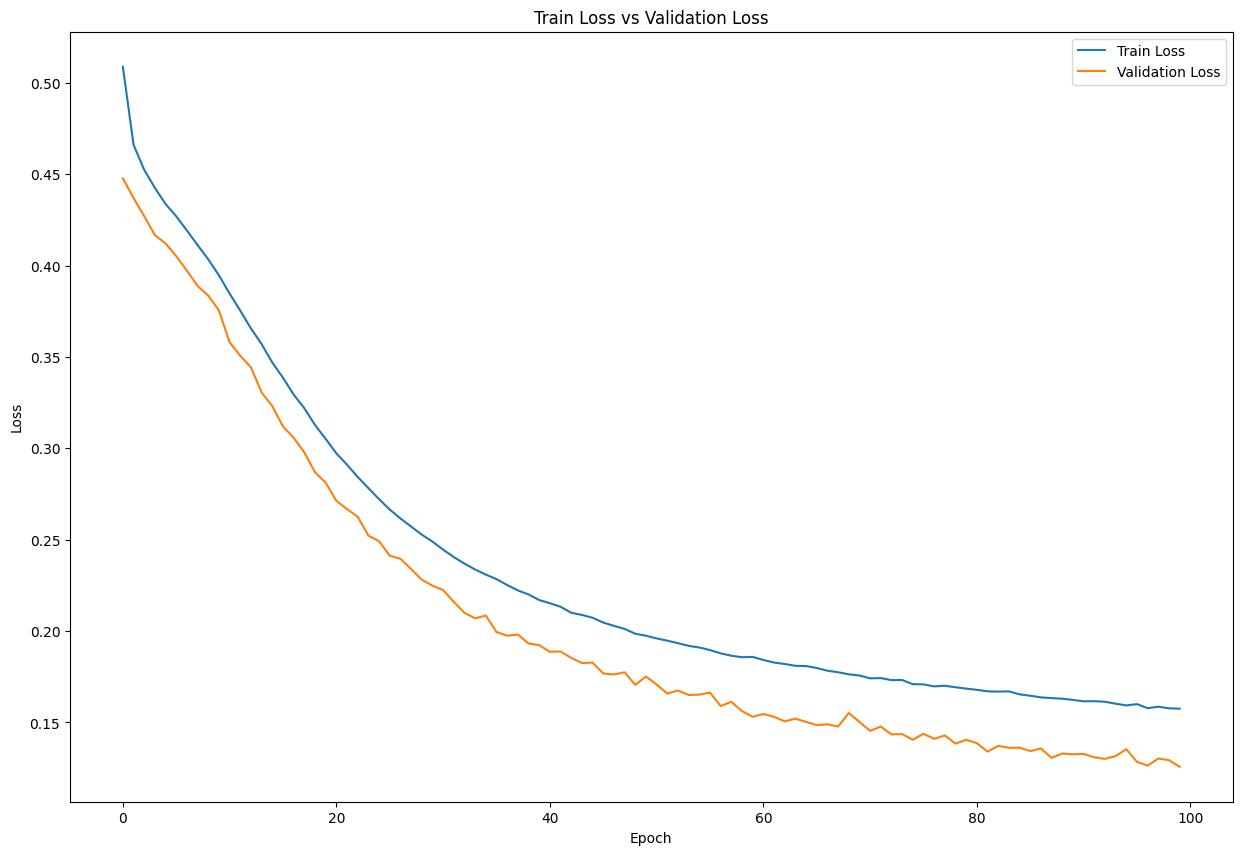

In [53]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss vs Validation Loss")
plt.legend()
plt.show()

### Evaluation

In [17]:
model.load_state_dict(torch.load('./.export/checkpoint-aug-lstm.pt'))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12164\3260620653.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./.export/checkpoint-aug-ls

<All keys matched successfully>

In [18]:
def rmse(pred, target):
    return np.sqrt(np.mean((pred - target)**2))

def mae(pred, target):
    return np.mean(np.abs(pred - target))

def mard(pred, target):
    return np.mean(np.abs(pred - target) / (np.abs(target) + 1e-6))

def mbe(pred, target):
    return np.mean(pred - target)

def mape(pred, target):
    return np.mean(np.abs((target - pred) / (target + 1e-6))) * 100

def pearson_r(pred, target):
    return np.corrcoef(pred, target)[0, 1]

def ccc(pred, target):
    pred_mean = np.mean(pred)
    target_mean = np.mean(target)
    pred_var = np.var(pred)
    target_var = np.var(target)
    covariance = np.mean((pred - pred_mean) * (target - target_mean))
    return (2 * covariance) / (pred_var + target_var + (pred_mean - target_mean)**2 + 1e-6)

In [20]:
model.eval()
preds = []
preds_targets = []

with torch.no_grad():
    for x_seq, targets in tqdm(test_loader, desc="Evaluation"):
        x_seq = x_seq.to(device)
        targets = targets.to(device)
        outputs = model(x_seq)
        preds.append(outputs.cpu().numpy())
        preds_targets.append(targets.cpu().numpy())
        
preds = np.concatenate(preds)
preds_targets = np.concatenate(preds_targets)

target_scaler = joblib.load('./.data/target_scaler_aug.pkl')
all_preds = target_scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
all_targets = target_scaler.inverse_transform(preds_targets.reshape(-1, 1)).flatten()

residuals = all_preds - all_targets

Evaluation: 100%|██████████| 139/139 [00:00<00:00, 174.22it/s]


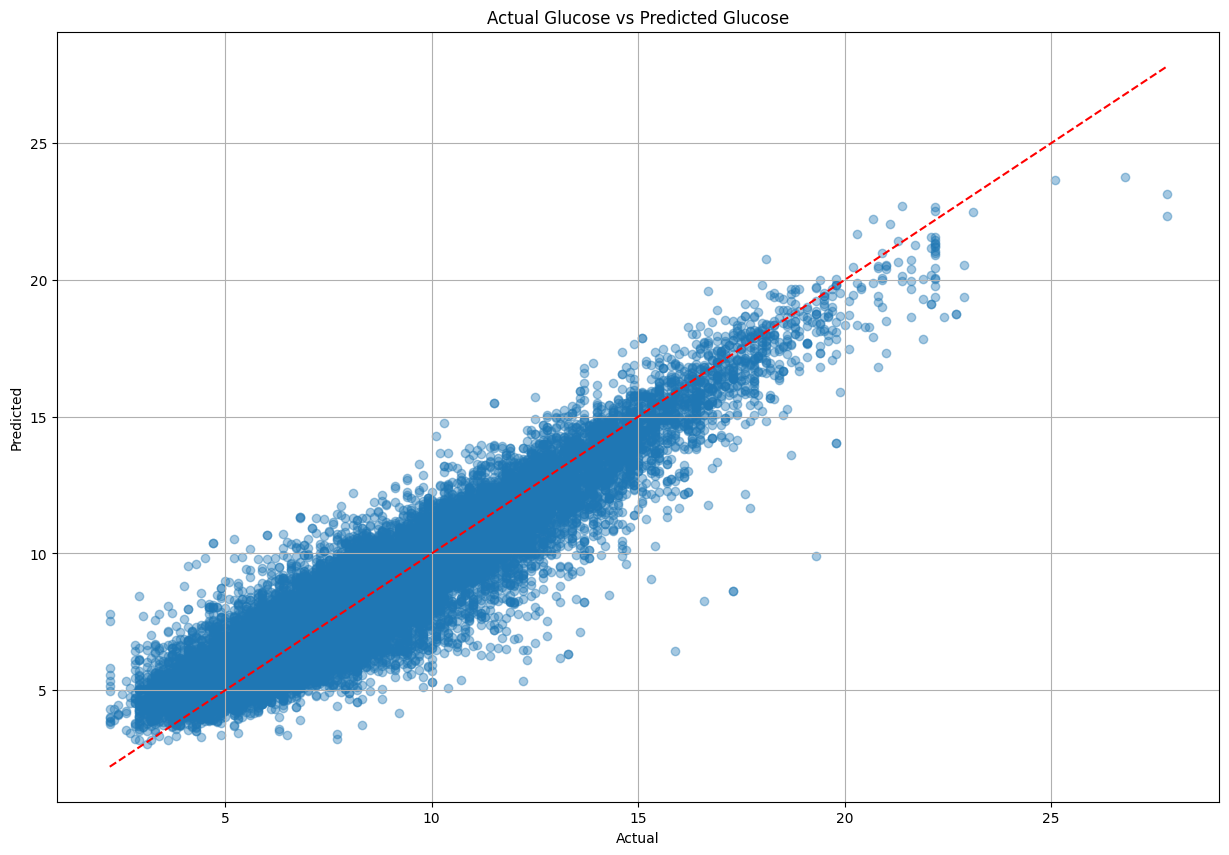

In [21]:
plt.figure(figsize=(15, 10))
plt.scatter(all_targets, all_preds, alpha=0.4)
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual Glucose vs Predicted Glucose")
plt.grid(True)
plt.show()

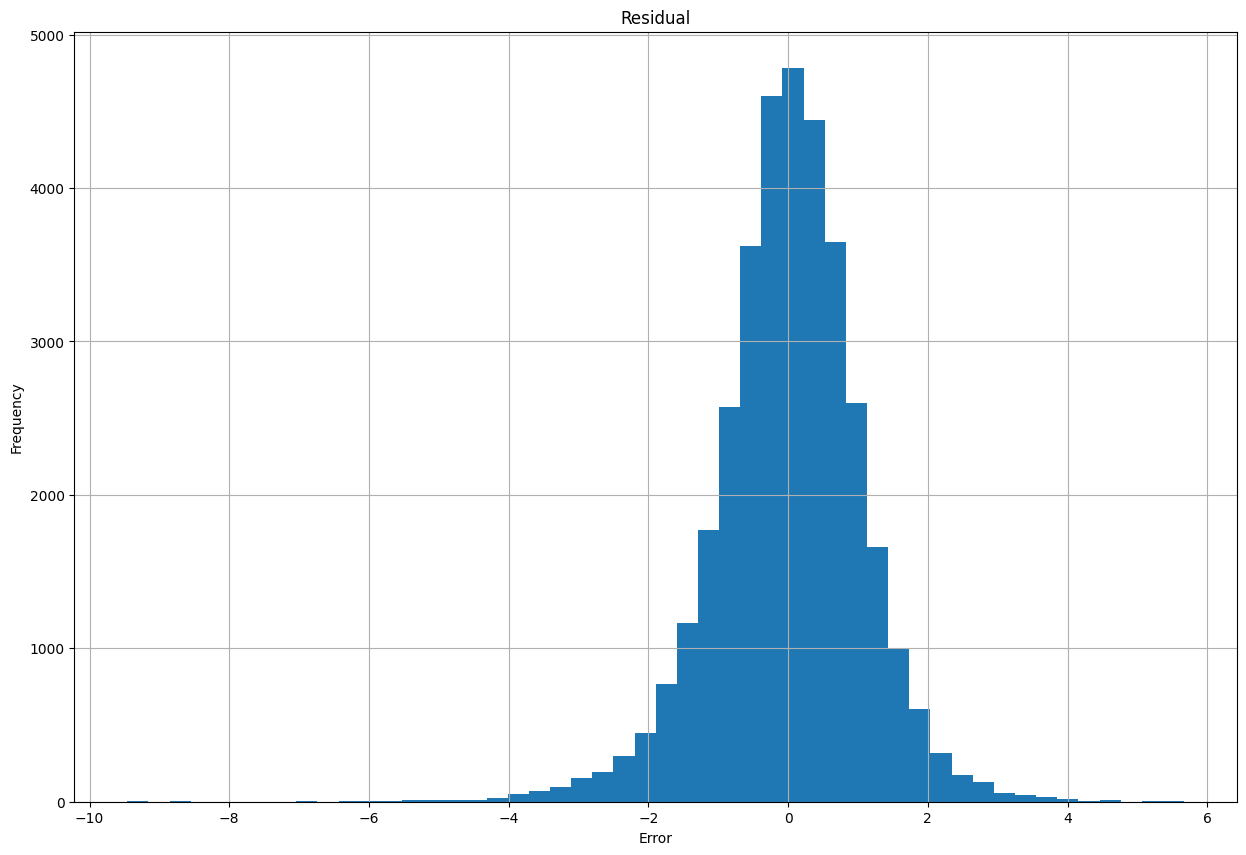

In [22]:
plt.figure(figsize=(15, 10))
plt.hist(residuals, bins=50)
plt.title("Residual")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [23]:
from sklearn.metrics import r2_score
test_r2 = r2_score(all_targets, all_preds)

In [24]:
from sklearn.metrics import explained_variance_score
test_expl_var = explained_variance_score(all_targets, all_preds)

In [25]:
test_rmse = rmse(all_preds, all_targets)
test_mae = mae(all_preds, all_targets)
test_mard = mard(all_preds, all_targets)

test_mbe = mbe(all_preds, all_targets)
test_r2 = r2_score(all_targets, all_preds)
test_expl_var = explained_variance_score(all_targets, all_preds)
test_mape = mape(all_preds, all_targets)
test_ccc = ccc(all_preds, all_targets)

In [26]:
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MSE: {test_rmse**2:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MARD: {test_mard:.4f}")
print(f"Test MBE: {test_mbe:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test Explained Variance: {test_expl_var:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Test CCC: {test_ccc:.4f}")

Test RMSE: 1.0522
Test MSE: 1.1072
Test MAE: 0.7836
Test MARD: 0.1061
Test MBE: -0.0020
Test R²: 0.8753
Test Explained Variance: 0.8753
Test MAPE: 10.61%
Test CCC: 0.9323


### Inference

In [64]:
df_test = pd.read_csv("./.data/test_aug.csv")

In [65]:
print(df_test)

            id   bg-1:55   bg-1:50   bg-1:45   bg-1:40   bg-1:35   bg-1:30  \
0     p01_8459  1.498370  1.484493  1.503679  1.531703  1.553799  1.622914   
1     p01_8460 -0.486487 -0.648439 -0.811465 -0.926369 -1.035974 -1.140981   
2     p01_8461 -1.101087 -1.091123 -1.083243 -1.078102 -1.066323 -1.050196   
3     p01_8462 -1.564556 -1.609264 -1.656996 -1.624340 -1.582254 -1.534382   
4     p01_8463 -1.443651 -1.533807 -1.626799 -1.664802 -1.693533 -1.715952   
...        ...       ...       ...       ...       ...       ...       ...   
3639   p24_256 -0.748448 -0.598134 -0.509490 -0.481286 -0.600973 -0.535748   
3640   p24_257 -0.839126 -0.598134 -0.388700 -0.329553 -0.297484 -0.354179   
3641   p24_258  0.339697  0.337539  0.305844  0.277379  0.218447  0.220792   
3642   p24_259 -0.476411 -0.477402 -0.479292 -0.450939 -0.388531 -0.354179   
3643   p24_260 -0.929805 -0.960330 -0.871860 -0.875791 -0.843764 -0.747580   

       bg-1:25   bg-1:20   bg-1:15  ...  cals-0:45  cals-0:40  

In [66]:
for col in df_test.columns:
    print(col)

id
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-1:55
insulin-1:50
insulin-1:45
insulin-1:40
insulin-1:35
insulin-1:30
insulin-1:25
insulin-1:20
insulin-1:15
insulin-1:10
insulin-1:05
insulin-1:00
insulin-0:55
insulin-0:50
insulin-0:45
insulin-0:40
insulin-0:35
insulin-0:30
insulin-0:25
insulin-0:20
insulin-0:15
insulin-0:10
insulin-0:05
insulin-0:00
carbs-1:55
carbs-1:50
carbs-1:45
carbs-1:40
carbs-1:35
carbs-1:30
carbs-1:25
carbs-1:20
carbs-1:15
carbs-1:10
carbs-1:05
carbs-1:00
carbs-0:55
carbs-0:50
carbs-0:45
carbs-0:40
carbs-0:35
carbs-0:30
carbs-0:25
carbs-0:20
carbs-0:15
carbs-0:10
carbs-0:05
carbs-0:00
hr-1:55
hr-1:50
hr-1:45
hr-1:40
hr-1:35
hr-1:30
hr-1:25
hr-1:20
hr-1:15
hr-1:10
hr-1:05
hr-1:00
hr-0:55
hr-0:50
hr-0:45
hr-0:40
hr-0:35
hr-0:30
hr-0:25
hr-0:20
hr-0:15
hr-0:10
hr-0:05
hr-0:00
steps-1:55
steps-1:50
steps-1:45
step

In [67]:
meta_data = ['id']
df_test_meta = df_test[meta_data]
df_test.drop(columns=meta_data, inplace=True)

In [68]:
infer_test_dataset = BrisT1DDataset(df_test, is_train=False)
infer_test_loader = DataLoader(infer_test_dataset, batch_size=256, shuffle=False)

In [69]:
model.load_state_dict(torch.load('./.export/checkpoint-aug-lstm.pt'))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_41516\3260620653.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./.export/checkpoint-aug-ls

<All keys matched successfully>

In [70]:
model.eval()

all_preds = []
with torch.no_grad():
    for x_seq in tqdm(infer_test_loader, desc="Inference"):
        x_seq = x_seq.to(device)
        outputs = model(x_seq)
        all_preds.append(outputs.cpu().numpy())

all_preds = np.concatenate(all_preds)

Inference: 100%|██████████| 15/15 [00:00<00:00, 59.38it/s]


In [71]:
target_scaler = joblib.load('./.data/target_scaler_aug.pkl')
all_preds_original = target_scaler.inverse_transform(all_preds.reshape(-1, 1)).flatten()

df_predictions = pd.DataFrame(all_preds_original, columns=["bg+1:00"])
df_results = pd.concat([df_test_meta.reset_index(drop=True), df_predictions], axis=1)
df_results.to_csv("./.export/test_submission_aug_lstm.csv", index=False)

### Submission

In [2]:
!kaggle competitions submit -c brist1d -f ./.export/test_submission_aug_lstm.csv -m "BrisT1D Submission: LSTM"

Successfully submitted to BrisT1D Blood Glucose Prediction Competition



  0%|          | 0.00/67.9k [00:00<?, ?B/s]
100%|██████████| 67.9k/67.9k [00:00<00:00, 72.2kB/s]


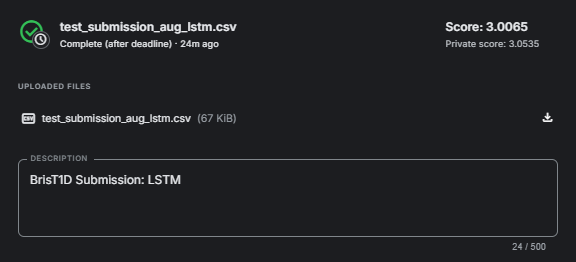

In [2]:
display(Image(filename='./.export/test_submission_aug_lstm.png'))